# Fake News detection

In [ ]:
import os
import re
import ssl
import pickle
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix, f1_score

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/richardph911/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/richardph911/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load Dataset

In [ ]:
df_true = pd.read_csv('data/True.csv')
df_fake = pd.read_csv('data/Fake.csv')
df_true.shape, df_fake.shape

((21417, 4), (23481, 4))

### Drop columns "subject" and "subject". Add column "label"

In [3]:
df_true.drop(['subject', 'date'], axis=1, inplace=True)
df_fake.drop(['subject', 'date'], axis=1, inplace=True)
df_true['label'] = 1
df_fake['label'] = 0
df_true.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


### Merge True and Fake dataset

In [4]:
df = pd.concat([df_true,df_fake]).sample(frac=1).reset_index(drop=True)
df.duplicated().sum()
df.drop_duplicates(inplace=True)
print(df.shape)
df.head()

(39105, 3)


,title,text,label
0,Fighting and air strikes in Yemen's Sanaa trap...,GENEVA (Reuters) - Fighting and air strikes ha...,1
1,Scope of Kerimov's immunity status up to judge...,PARIS (Reuters) - The scope of the immunity st...,1
2,FATHER OF HIGH SCHOOL FOOTBALL STAR SHOT AND K...,They shot him in the head with a 45. They fo...,0
3,Mistrial declared in corruption case against e...,LOS ANGELES (Reuters) - A federal judge declar...,1
4,French union says will not join far-left prote...,PARIS (Reuters) - France s hardline CGT union ...,1


### Data preprocessing

In [ ]:
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)
df['text'] = df['text'].apply(preprocess_text)

### Text Length Distribution

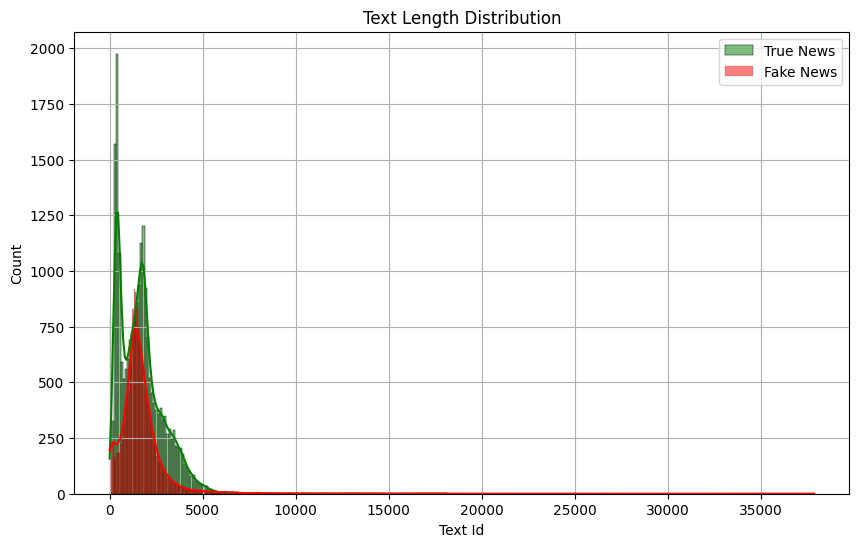

In [ ]:
plt.figure(figsize=(10, 6))
sns.color_palette("Set2")
sns.histplot(df[df['label'] == 1]['text'].str.len(), label='True News', color='g', kde = True)
sns.histplot(df[df['label'] == 0]['text'].str.len(), label='Fake News', color='r', kde = True)
plt.xlabel('Text Id')
plt.ylabel('Count')
plt.title('Text Length Distribution')
plt.grid(True)
plt.legend()
plt.show()

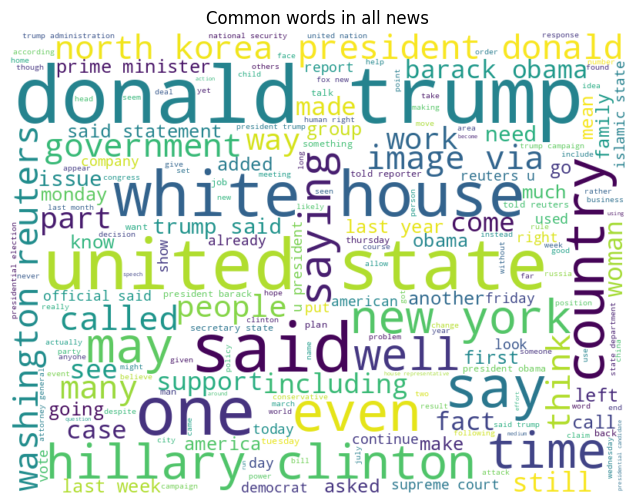

In [ ]:
def plot_word_cloud(title, text):
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

all_text = ' '.join(df['text'])
plot_word_cloud('Common words in all news', all_text)

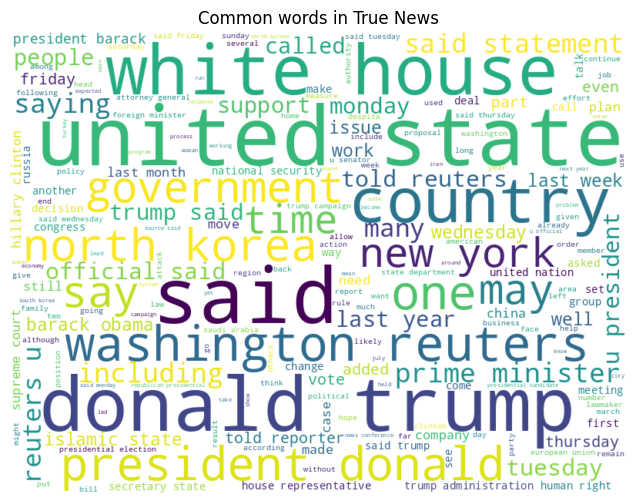

In [ ]:
df_true_text = ' '.join(df[df['label'] == 1]['text'])
plot_word_cloud('Common words in True News', df_true_text)

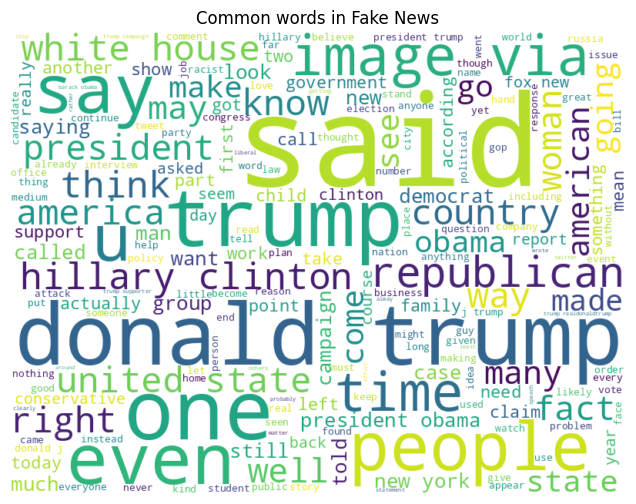

In [ ]:
df_fake_text = ' '.join(df[df['label'] == 0]['text'])
plot_word_cloud('Common words in Fake News', df_fake_text)

### Feature Extraction

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['text'])
y = df['label']

In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training


Logistic Regression -> Accuracy: 0.9864, F1 Score: 0.9875
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.99      3618
        Real       0.98      0.99      0.99      4203

    accuracy                           0.99      7821
   macro avg       0.99      0.99      0.99      7821
weighted avg       0.99      0.99      0.99      7821


Naive Bayes -> Accuracy: 0.9215, F1 Score: 0.9277
              precision    recall  f1-score   support

        Fake       0.93      0.90      0.91      3618
        Real       0.92      0.94      0.93      4203

    accuracy                           0.92      7821
   macro avg       0.92      0.92      0.92      7821
weighted avg       0.92      0.92      0.92      7821


Gradient Boosting -> Accuracy: 0.9946, F1 Score: 0.9950
              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      3618
        Real       0.99      1.00      1.00      4203

    accuracy   

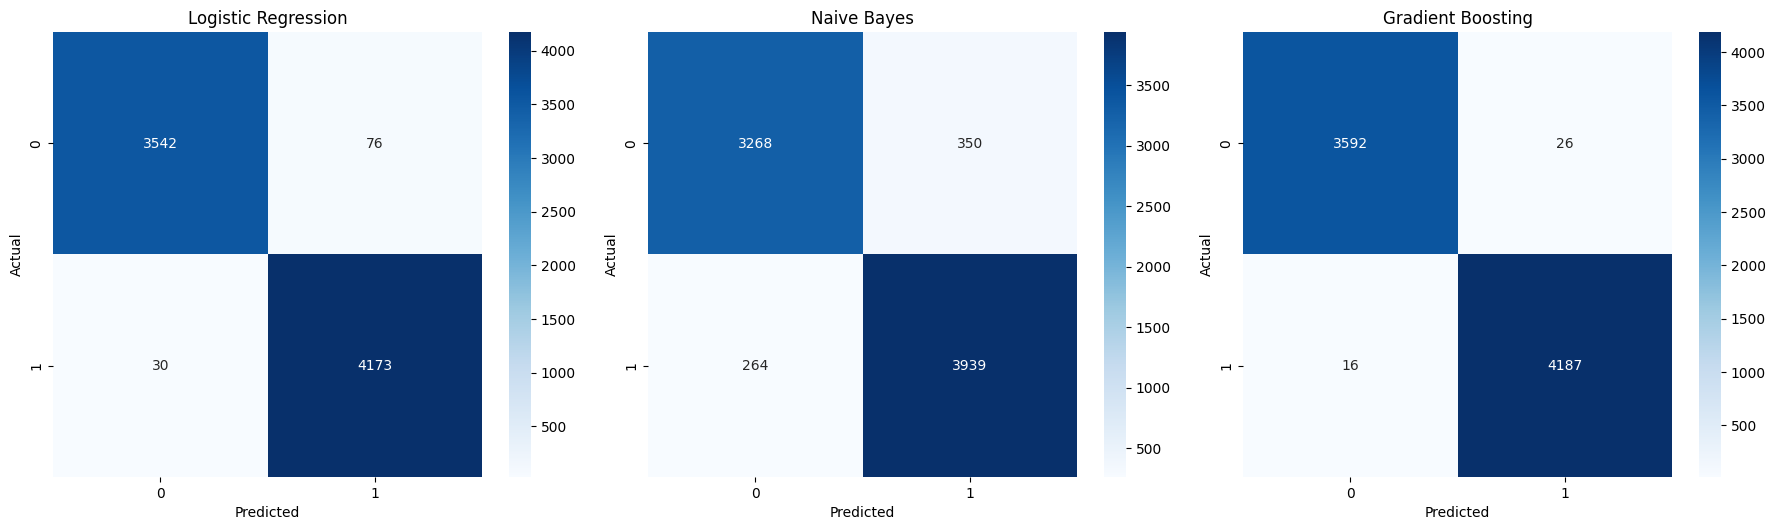

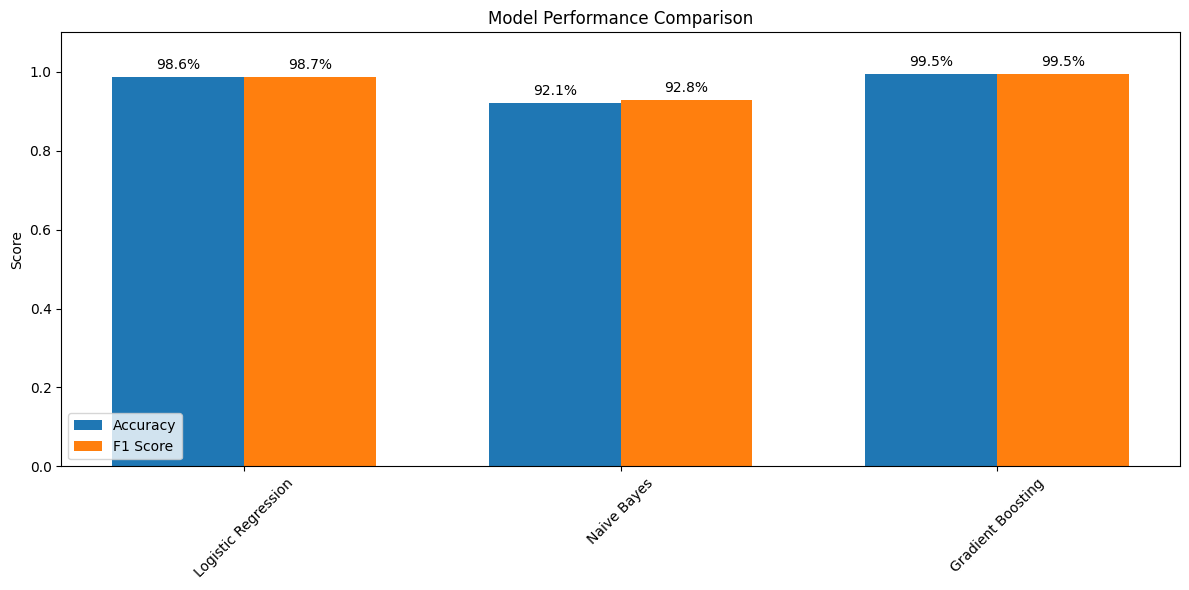

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    # "SVM": SVC(C=1.0, kernel='linear', probability=True),
    # "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.8),
    # "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Train models and collect results
results = {}
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    trained_models[name] = model 
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "accuracy": acc,
        "f1": f1,
        "confusion_matrix": cm,
        "y_pred": y_pred  
    }

    print(f"\n{name} -> Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

def model_score(res, f1_weight=0.6, acc_weight=0.4):
    return f1_weight * res['f1'] + acc_weight * res['accuracy']

# Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (name, res) in enumerate(results.items()):
    sns.heatmap(res['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Hide unused subplots if less than 6 models
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Accuracy and F1 Score 
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
f1_scores = [results[name]['f1'] for name in model_names]

plt.figure(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.35

bars1 = plt.bar(x - width / 2, accuracies, width, label='Accuracy')
bars2 = plt.bar(x + width / 2, f1_scores, width, label='F1 Score')

plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names, rotation=45)
plt.ylim(0, 1.1) 

# Add percentage labels
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height*100:.1f}%', ha='center')

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height*100:.1f}%', ha='center')

plt.legend()
plt.tight_layout()
plt.show()

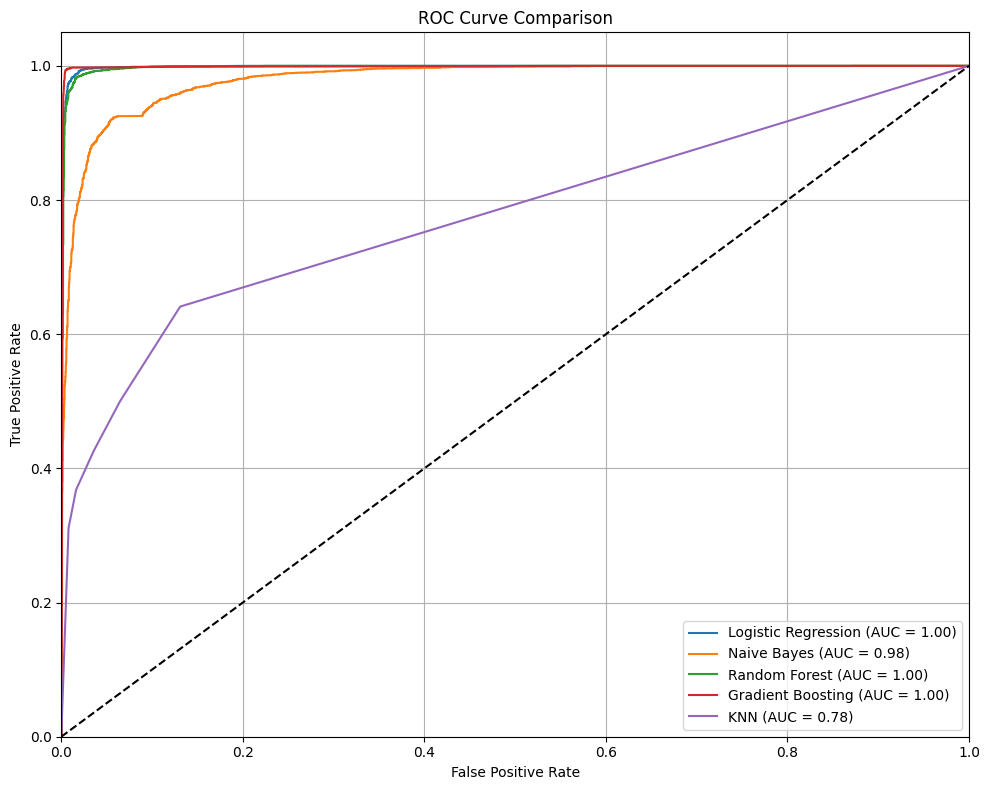

Logistic Regression: Mean Accuracy = 0.9855, Std = 0.0020
Naive Bayes: Mean Accuracy = 0.9217, Std = 0.0069
Random Forest: Mean Accuracy = 0.9811, Std = 0.0090
Gradient Boosting: Mean Accuracy = 0.9944, Std = 0.0002
KNN: Mean Accuracy = 0.6772, Std = 0.0012


In [ ]:
plt.figure(figsize=(10, 8))
trained_models = {}              

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    trained_models[name] = model

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

cv_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_scores[name] = scores
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}, Std = {scores.std():.4f}")

In [46]:
# Calculate weighted scores for each model
def model_score(res, f1_weight=0.6, acc_weight=0.4):
    return f1_weight * res['f1'] + acc_weight * res['accuracy']

scores = {name: model_score(res) for name, res in results.items()}
best_model = max(scores, key=scores.get)
best_score = scores[best_model]
best_model_name = model_names[np.argmax(accuracies)]
best_model = trained_models[best_model_name]

print(f"Best model: {best_model} with score: {best_score:.4f}")

Best model: GradientBoostingClassifier(subsample=0.8) with score: 0.9949


### Save model and vectorizer for deployment

In [ ]:
os.makedirs('models', exist_ok=True) # make directory if it doesn't exist
with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

### Deploy

In [50]:
def detectNews(text):

    with open("models/best_model.pkl", "rb") as f:
        model = pickle.load(f)
    print("best model saved as ", type(model).__name__)

    with open('models/tfidf_vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)

    """Classify news text as Real or Fake."""
    processed_text = preprocess_text(text)
    text_vector = vectorizer.transform([processed_text])
    prediction = model.predict(text_vector)
    probability = model.predict_proba(text_vector)

    label = "Real News" if prediction[0] == 1 else "Fake News"
    confidence = probability[0][prediction[0]]

    return label, confidence

In [ ]:
sample_text = "hello world"
result, confidence = detectNews(sample_text)
print(f"Result: {result} with confidence: {confidence:.2f}")

best model saved as  GradientBoostingClassifier
Result: Fake News with confidence: 1.00


# References:
1. https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data
